# Bees vs Wasps notebook

Andmete URL: https://www.kaggle.com/jerzydziewierz/bee-vs-wasp#

#### Kasutatud materjal
- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
- https://www.kaggle.com/koshirosato/bee-or-wasp-base-line-using-resnet50/notebook

#### Grupp
- Patrick Lomp
- Artti Raasuke

#### Impordid

In [10]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# additional classic imports
from pathlib import Path
import pandas as pd
import numpy as np
import random
import os
import gc
import cv2


from tensorflow.keras.layers import *
from keras.optimizers import Adam
from tqdm import tqdm

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

AttributeError: module 'tensorflow' has no attribute 'config'

In [12]:
# pip3 install --upgrade tensorflow-gpu

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13035297398545803232
]


#### Parameetrid

In [13]:
bs = 32 # Batch size
resize_size = 96 # for training, resize all the images to a square of this size
training_subsample = 0.1 # for development, use a small fraction of the entire dataset rater than full dataset
ROOT = './data'
IMG_SIZE = 256
EPOCHS = 20

## Andmestikude loomine




In [14]:
bees_vs_wasps_dataset_path=Path(ROOT) # this is relative to the "example_notebook" folder. Modify this to reflect your setup
df_labels = pd.read_csv(bees_vs_wasps_dataset_path/'labels.csv')
df_labels=df_labels.set_index('id')
# perform dataset subsampling
df_labels = df_labels.sample(frac=training_subsample, axis=0)

In [15]:
for idx in tqdm(df_labels.index):    
    df_labels.loc[idx,'path']=df_labels.loc[idx,'path'].replace('\\', '/') 
    
df_labels.head()

100%|████████████████████████████████████████████████████████████████████████████| 1142/1142 [00:00<00:00, 1202.72it/s]


path  is_bee  is_wasp  is_otherinsect  \
id                                                                         
6944                   wasp2/I00203.jpg       0        1               0   
1395   bee1/4283836970_64852c8f8e_n.jpg       1        0               0   
323     bee1/161153532_0a36546adf_m.jpg       1        0               0   
11155         other_noinsect/556636.jpg       0        0               0   
2052   bee1/7205861494_3ac9467504_n.jpg       1        0               0   

       is_other  photo_quality  is_validation  is_final_validation  label  
id                                                                         
6944          0              0              0                    0   wasp  
1395          0              1              0                    1    bee  
323           0              1              0                    0    bee  
11155         1              0              0                    0  other  
2052          0              1              1                    0    bee

In [16]:
#Andmete kättesaamine algse csv järgi
train_df = df_labels.query('is_validation == 0 & is_final_validation == 0').reset_index(drop=True)
val_df = df_labels.query('is_validation == 1').reset_index(drop=True)
test_df = df_labels.query('is_final_validation == 1').reset_index(drop=True)

In [17]:
#Meetod admestikude loomiseks pildi failidega
def create_datasets(df, img_size):
    imgs = []
    for path in tqdm(df['path']):
        img = cv2.imread(ROOT+"/"+path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size,img_size))
        imgs.append(img)

    imgs = np.array(imgs, dtype='float32')
    imgs = imgs / 255.0
    df = pd.get_dummies(df['label'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, IMG_SIZE)
val_imgs, val_df = create_datasets(val_df, IMG_SIZE)
test_imgs, test_df = create_datasets(test_df, IMG_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 83.00it/s]


## Andmete puhastamine

In [18]:
print("andmestiku suurus enne puhastust:", str(df_labels.size))
df_beesandwasps = df_labels[df_labels['photo_quality'] == 1]
print(df_beesandwasps.size)
df_other = df_labels[df_labels['label'] == 'other']
df_otherinsect = df_labels[df_labels['label'] == 'insect']

df_clean = df_beesandwasps.append(df_other).append(df_otherinsect)
print("andmestiku suurus pärast puhastust:", str(df_clean.size))

andmestiku suurus enne puhastust: 10278
6246
andmestiku suurus pärast puhastust: 9099


## Andmete visualiseerimine

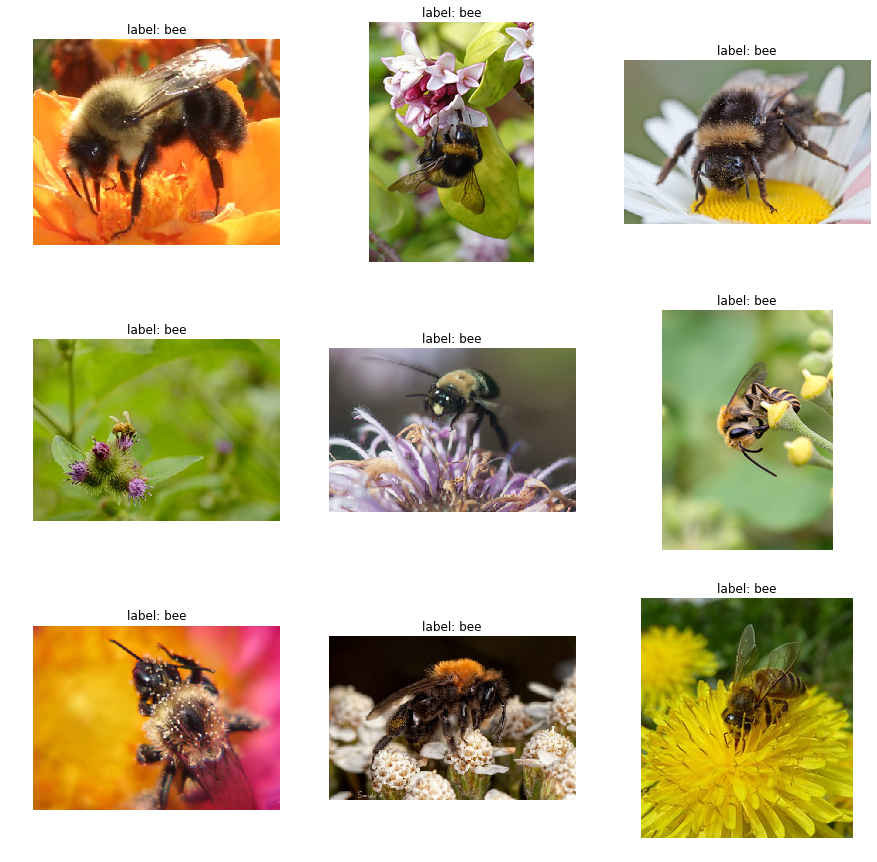

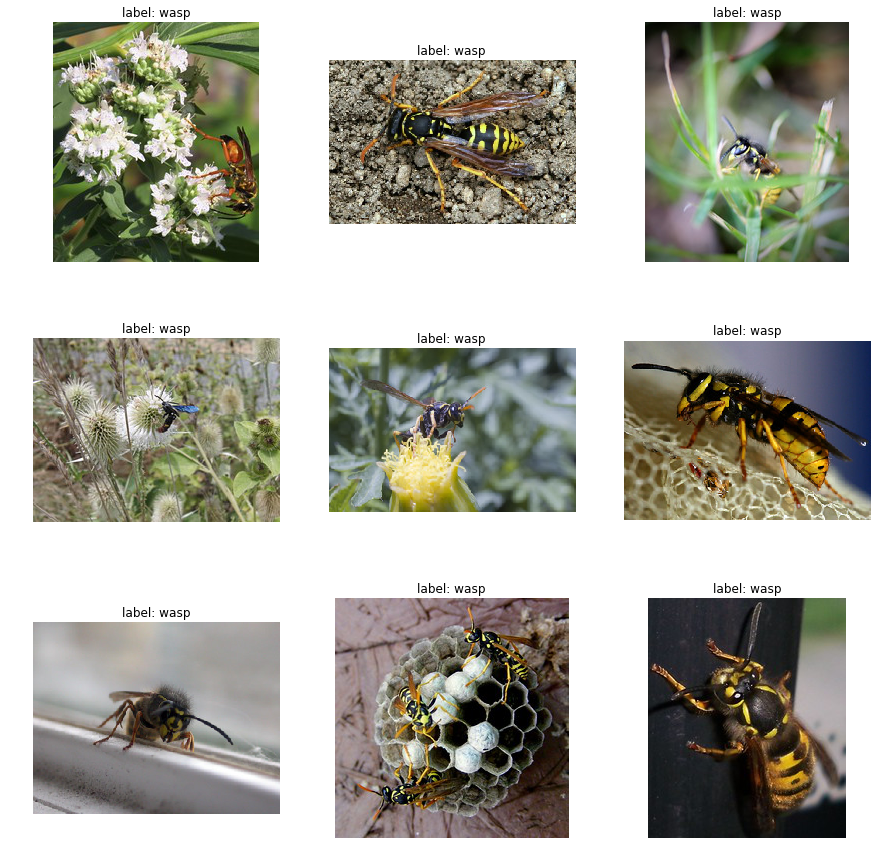

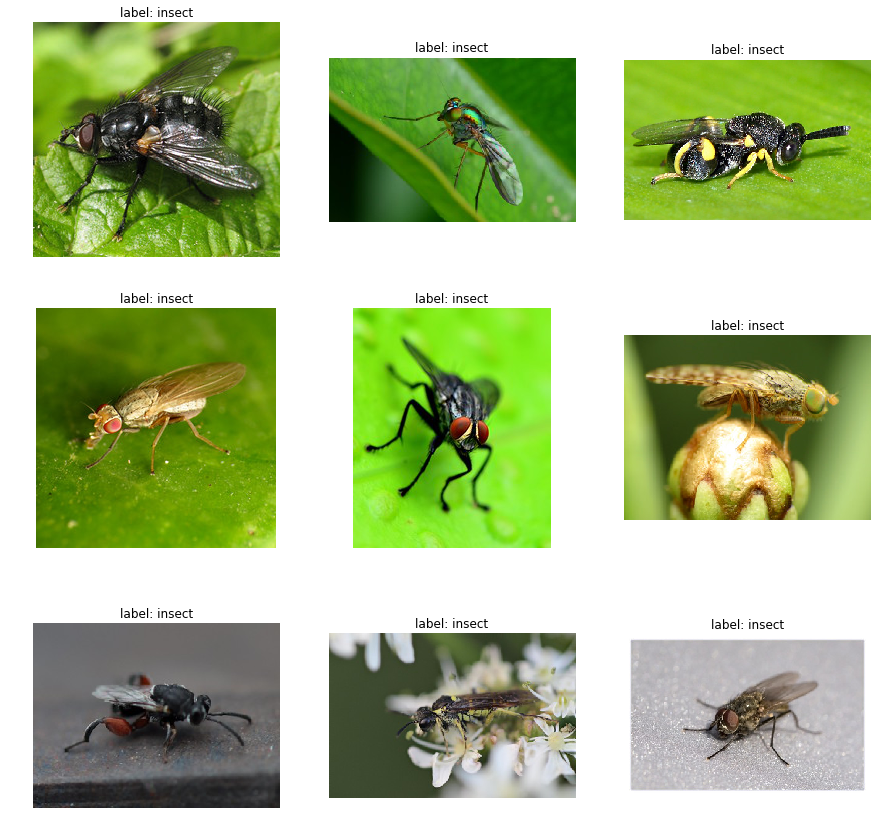

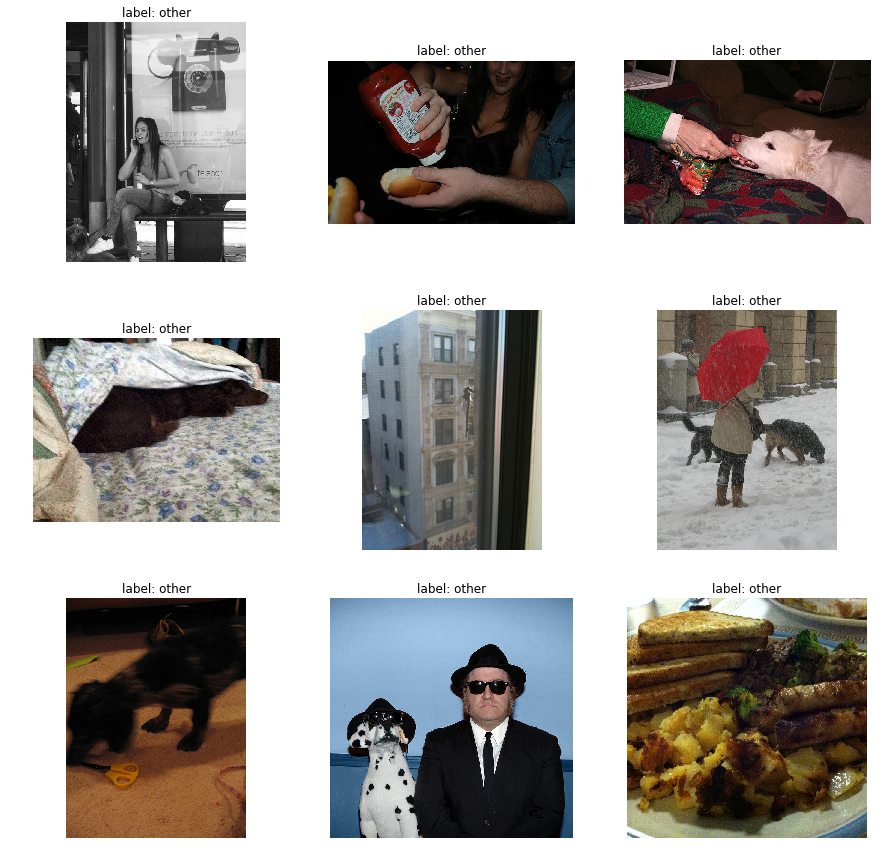

In [19]:
def img_plot(df, label):
    df = df.query('label == @label')
    imgs = []
    for path in df['path'][:9]:
        img = cv2.imread('data\\'+path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
    f, ax = plt.subplots(3, 3, figsize=(15,15))
    for i, img in enumerate(imgs):
        ax[i//3, i%3].imshow(img)
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('label: %s' % label)
    plt.show()
    


img_plot(df_clean, label='bee')
img_plot(df_clean, label='wasp')
img_plot(df_clean, label='insect')
img_plot(df_clean, label='other')

## Närvivõrgu loomine ja treenimine

In [9]:
#Närvivõrk
def make_model(img_size, n):
    inp = Input(shape=(img_size,img_size,n))
    resnet = tf.keras.applications.ResNet50(input_shape=(img_size,img_size,n), 
                                            weights='imagenet', 
                                            include_top=False)
    x = resnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x) 
    opt = tf.keras.optimizers.SGD(momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

    model = Model(inputs=x, outputs=p)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
    model.summary()
    return model

model = make_model(IMG_SIZE, 3)

In [10]:
print(train_imgs.shape)
print(train_df.shape)

(808, 256, 256, 3)
(808, 4)


In [13]:
#Mudeli treenimine
history = model.fit(train_imgs, 
                    train_df, 
                    batch_size=bs, 
                    epochs=EPOCHS,
                    validation_data=(val_imgs, val_df)
                   )

Epoch 1/20
26/26 [==============================] - 577s 22s/step - loss: 0.4013 - accuracy: 0.8700 - val_loss: 1.7111 - val_accuracy: 0.4371
Epoch 2/20
26/26 [==============================] - 588s 23s/step - loss: 0.5444 - accuracy: 0.8255 - val_loss: 6.6114 - val_accuracy: 0.4371
Epoch 3/20
 2/26 [=>............................] - ETA: 8:28 - loss: 0.4535 - accuracy: 0.8906

KeyboardInterrupt: 

## Testimine

In [14]:
#Test hulgal täpsu
model.evaluate(test_imgs, test_df) 

6/6 [==============================] - 20s 3s/step - loss: 3.6030 - accuracy: 0.4491


[3.6029977798461914, 0.4491018056869507]